In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests
import random

In [5]:
!pip install -U duckduckgo-search

  Using cached duckduckgo_search-8.1.1-py3-none-any.whl.metadata (16 kB)
  Using cached primp-0.15.0-cp38-abi3-macosx_11_0_arm64.whl.metadata (13 kB)
Using cached duckduckgo_search-8.1.1-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 1.4 MB/s eta 0:00:00a 0:00:01m
Using cached primp-0.15.0-cp38-abi3-macosx_11_0_arm64.whl (3.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [duckduckgo-search]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI()

In [6]:
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}


@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=X9JSPO4TKEMQ0HVM"
    r = requests.get(url)
    return r.json()

In [7]:
# Make tool list
tools = [get_stock_price, search_tool, calculator]

# Make the LLM tool-aware
llm_with_tools = llm.bind_tools(tools)

In [8]:
# state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [9]:
# graph nodes
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)  # Executes tool calls

In [10]:
# graph structure
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [11]:
graph.add_edge(START, "chat_node")

# If the LLM asked for a tool, go to ToolNode; else finish
graph.add_conditional_edges("chat_node", tools_condition)

graph.add_edge("tools", "chat_node")    

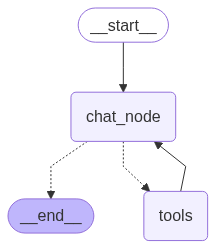

In [12]:
chatbot = graph.compile()

chatbot

In [13]:
# Regular chat
out = chatbot.invoke({"messages": [HumanMessage(content="Hello!")]})

print(out["messages"][-1].content)

Hi there! How can I assist you today?


In [14]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2*3?")]})
print(out["messages"][-1].content)

The result of 2 multiplied by 3 is 6.


In [15]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of apple")]})
print(out["messages"][-1].content)

The current stock price of Apple (AAPL) is $238.47.


In [16]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="First find out the stock price of Apple using get stock price tool then use the calculator tool to find out how much will it take to purchase 50 shares?")]})
print(out["messages"][-1].content)

The current stock price of Apple (AAPL) is $238.47 per share.

To purchase 50 shares of AAPL, it will cost $11,923.50.
